<a class="anchor" id="0"></a>

# Used Cars Price Prediction by 15 different models

Build of the 15 most popular models, the most complex models from them are tuned (optimized)

Comparison of the optimal for each type models.

This kernel is based on the my kernels:
* "[BOD prediction in river - 15 regression models](https://www.kaggle.com/vbmokin/bod-prediction-in-river-15-regression-models)"
* [Automatic selection from 20 classifier models](https://www.kaggle.com/vbmokin/automatic-selection-from-20-classifier-models)

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
1. [Download datasets](#2)
1. [EDA](#3)
1. [Preparing to modeling](#4)
1. [Tuning models](#5)
    -  [Linear Regression](#5.1)
    -  [Support Vector Machines](#5.2)
    -  [Linear SVR](#5.3)
    -  [MLPRegressor](#5.4)
    -  [Stochastic Gradient Descent](#5.5)
    -  [Decision Tree Regressor](#5.6)
    -  [Random Forest with GridSearchCV](#5.7)
    -  [XGB](#5.8)
    -  [LGBM](#5.9)
    -  [GradientBoostingRegressor with HyperOpt](#5.10)
    -  [RidgeRegressor](#5.11)
    -  [BaggingRegressor](#5.12)
    -  [ExtraTreesRegressor](#5.13)
    -  [AdaBoost Regressor](#5.14)
    -  [VotingRegressor](#5.15)
1. [Models comparison](#6)
1. [Prediction](#7)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

## 2. Download datasets <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [2]:
valid_part = 0.3
pd.set_option('max_columns',100)

In [3]:
train0 = pd.read_csv('/kaggle/input/craigslist-carstrucks-data/craigslistVehicles.csv')
train0.head(5)

,url,city,city_url,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,desc,lat,long
0,https://grandrapids.craigslist.org/cto/d/hasti...,"grand rapids, MI",https://grandrapids.craigslist.org,1500,2006.0,cadillac,cts,good,6 cylinders,gas,236000.0,clean,automatic,NaN,rwd,mid-size,coupe,blue,https://images.craigslist.org/00K0K_a9CZoZg2U8...,"2006 CtS Leather, Runs and drives Good.236k mil",42.643000,-85.293700
1,https://grandrapids.craigslist.org/cto/d/grand...,"grand rapids, MI",https://grandrapids.craigslist.org,8900,2009.0,lincoln,mkx,NaN,NaN,gas,119000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00a0a_9B4kPBDIWd...,"Selling our loaded 2009 Lincoln MKX with 119,0...",42.973700,-85.726500
2,https://grandrapids.craigslist.org/ctd/d/chesa...,"grand rapids, MI",https://grandrapids.craigslist.org,7995,2010.0,cadillac,srx premium collection,NaN,NaN,gas,129105.0,clean,automatic,3GYFNCEYXAS552363,NaN,NaN,NaN,NaN,https://images.craigslist.org/00X0X_8i0VRuk7Cv...,WE HAVE OVER 400 VEHICLES IN STOCK!\n\n View O...,43.186723,-84.163862
3,https://grandrapids.craigslist.org/ctd/d/chesa...,"grand rapids, MI",https://grandrapids.craigslist.org,6995,2007.0,NaN,hummer h3 4dr 4wd suv,NaN,NaN,gas,164296.0,clean,automatic,5GTDN13E478107380,NaN,NaN,NaN,NaN,https://images.craigslist.org/00b0b_ahkmUzr4cE...,WE HAVE OVER 400 VEHICLES IN STOCK!\n\n View O...,43.186723,-84.163862
4,https://grandrapids.craigslist.org/ctd/d/caled...,"grand rapids, MI",https://grandrapids.craigslist.org,20990,2010.0,ram,2500,excellent,6 cylinders,diesel,123213.0,clean,automatic,3D7UT2CL4AG113236,4wd,NaN,NaN,white,https://images.craigslist.org/00505_3DHY0kFrgb...,Great looking 2010 Ram 2500 ST w/6.7L 24V I6 4...,42.783714,-85.506777


In [4]:
drop_columns = ['url', 'city', 'city_url', 'make', 'title_status', 'VIN', 'size', 'image_url', 'desc', 'lat','long']
train0 = train0.drop(columns = drop_columns)

In [5]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525839 entries, 0 to 525838
Data columns (total 11 columns):
price           525839 non-null int64
year            524399 non-null float64
manufacturer    501260 non-null object
condition       279881 non-null object
cylinders       315439 non-null object
fuel            521544 non-null object
odometer        427248 non-null float64
transmission    521572 non-null object
drive           374475 non-null object
type            376906 non-null object
paint_color     354306 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 44.1+ MB


In [6]:
train0 = train0.dropna()
train0.head(5)

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
0,1500,2006.0,cadillac,good,6 cylinders,gas,236000.0,automatic,rwd,coupe,blue
5,4950,2010.0,subaru,good,4 cylinders,gas,253000.0,automatic,4wd,sedan,white
6,6850,2007.0,gmc,good,8 cylinders,gas,254000.0,automatic,4wd,wagon,black
7,7995,2007.0,lexus,excellent,6 cylinders,gas,146111.0,automatic,fwd,sedan,white
8,4995,2011.0,hyundai,excellent,4 cylinders,gas,115048.0,automatic,fwd,sedan,blue


In [7]:
# from the my kernel: https://www.kaggle.com/vbmokin/automatic-selection-from-20-classifier-models
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train0.columns.values.tolist()
for col in features:
    if train0[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        le.fit(list(train0[col].astype(str).values))
        train0[col] = le.transform(list(train0[col].astype(str).values))

In [8]:
train0['year'] = (train0['year']-1900).astype(int)
train0['odometer'] = train0['odometer'].astype(int)

In [9]:
train0.head(10)

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
0,1500,106,6,2,5,2,236000,0,2,3,1
5,4950,110,36,2,3,2,253000,0,0,9,10
6,6850,107,14,2,6,2,254000,0,0,12,0
7,7995,107,23,0,5,2,146111,0,1,9,10
8,4995,111,17,0,3,2,115048,0,1,9,1
9,12995,113,37,0,3,2,72936,0,1,4,10
12,8000,110,3,2,5,2,150000,0,0,9,5
18,6995,111,7,0,5,2,102000,0,1,9,1
21,39000,117,7,0,6,2,43300,0,2,9,5
24,8900,112,33,2,6,2,112000,0,2,8,10


In [10]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144903 entries, 0 to 525836
Data columns (total 11 columns):
price           144903 non-null int64
year            144903 non-null int64
manufacturer    144903 non-null int64
condition       144903 non-null int64
cylinders       144903 non-null int64
fuel            144903 non-null int64
odometer        144903 non-null int64
transmission    144903 non-null int64
drive           144903 non-null int64
type            144903 non-null int64
paint_color     144903 non-null int64
dtypes: int64(11)
memory usage: 13.3 MB


## 3. EDA <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

This code is based on my kernel "[FE & EDA with Pandas Profiling](https://www.kaggle.com/vbmokin/fe-eda-with-pandas-profiling)"

In [11]:
train0['price'].value_counts()

0        6755
1        1743
4500     1603
3500     1593
2500     1528
         ... 
11881       1
24295       1
53          1
9960        1
4925        1
Name: price, Length: 6578, dtype: int64

In [12]:
train0 = train0[train0['price'] > 1000]
train0 = train0[train0['price'] < 40000]
# Rounded ['odometer'] to 5000
train0['odometer'] = train0['odometer'] // 5000
train0 = train0[train0['year'] > 110]

In [13]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61500 entries, 8 to 525835
Data columns (total 11 columns):
price           61500 non-null int64
year            61500 non-null int64
manufacturer    61500 non-null int64
condition       61500 non-null int64
cylinders       61500 non-null int64
fuel            61500 non-null int64
odometer        61500 non-null int64
transmission    61500 non-null int64
drive           61500 non-null int64
type            61500 non-null int64
paint_color     61500 non-null int64
dtypes: int64(11)
memory usage: 5.6 MB


In [14]:
train0.corr()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
price,1.000000,0.458124,-0.024179,0.061167,0.531244,-0.208566,-0.184752,0.105238,-0.267012,0.061335,0.030263
year,0.458124,1.000000,0.045498,0.111609,-0.078526,0.069939,-0.296953,0.036089,0.010158,0.026916,0.040059
manufacturer,-0.024179,0.045498,1.000000,-0.009447,-0.201032,-0.065246,-0.021403,0.026844,-0.101821,0.026859,-0.003125
condition,0.061167,0.111609,-0.009447,1.000000,0.016719,0.038039,-0.054486,0.121792,0.061101,0.028917,0.022872
cylinders,0.531244,-0.078526,-0.201032,0.016719,1.000000,-0.109350,0.066435,0.052527,-0.153713,0.096659,0.037153
fuel,-0.208566,0.069939,-0.065246,0.038039,-0.109350,1.000000,-0.089144,0.068673,0.096037,-0.132572,-0.042783
odometer,-0.184752,-0.296953,-0.021403,-0.054486,0.066435,-0.089144,1.000000,-0.074429,-0.046763,0.020417,0.022202
transmission,0.105238,0.036089,0.026844,0.121792,0.052527,0.068673,-0.074429,1.000000,0.064781,-0.007124,-0.026939
drive,-0.267012,0.010158,-0.101821,0.061101,-0.153713,0.096037,-0.046763,0.064781,1.000000,0.118371,0.073252
type,0.061335,0.026916,0.026859,0.028917,0.096659,-0.132572,0.020417,-0.007124,0.118371,1.000000,0.069675


In [15]:
train0.describe()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
count,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000
mean,16753.402407,114.093057,18.171024,1.037512,4.452244,1.915122,16.275382,0.117220,0.687545,6.161366,5.612894
std,8634.636138,2.198127,10.783879,1.227185,1.273357,0.509889,18.522399,0.423922,0.726215,4.185255,4.075558
min,1025.000000,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9900.000000,112.000000,10.000000,0.000000,3.000000,2.000000,9.000000,0.000000,0.000000,0.000000,1.000000
50%,14997.000000,114.000000,14.000000,0.000000,5.000000,2.000000,15.000000,0.000000,1.000000,8.000000,7.000000
75%,22500.000000,116.000000,30.000000,2.000000,6.000000,2.000000,22.000000,0.000000,1.000000,9.000000,10.000000
max,39999.000000,120.000000,39.000000,5.000000,7.000000,4.000000,1926.000000,2.000000,2.000000,12.000000,11.000000


In [16]:
pp.ProfileReport(train0)

## 4. Preparing to modeling <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [17]:
target_name = 'price'
train_target0 = train0[target_name]
train0 = train0.drop([target_name], axis=1)

In [18]:
# Synthesis test0 from train0
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)

In [19]:
# For boosting model
train0b = train0
train_target0b = train_target0
# Synthesis valid as test for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)

In [20]:
#For models from Sklearn
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [21]:
train0.head(3)

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
0,0.863012,1.738647,-0.847094,0.427812,0.165521,-0.469822,-0.277197,-0.946534,0.914222,0.830914
1,0.408926,0.627842,1.595253,-1.141380,0.165521,-0.266986,-0.277197,-0.946534,-1.478710,0.585384
2,-1.407417,1.923781,-0.847094,-0.356784,0.165521,0.392231,-0.277197,0.429470,-1.000124,0.585384


In [22]:
len(train0)

49200

In [23]:
# Synthesis valid as test for selection models
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [24]:
train.head(3)

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
27131,-0.499245,-0.482963,0.781138,0.427812,0.165521,0.341522,-0.277197,-0.946534,-1.478710,-1.378855
26736,-0.499245,-0.112695,-0.847094,-1.141380,0.165521,-0.064150,-0.277197,0.429470,0.674928,-1.378855
45445,-1.407417,1.368378,-0.847094,1.212408,0.165521,0.189395,-0.277197,-0.946534,0.914222,-1.378855


In [25]:
test.head(3)

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
44567,-0.045159,0.165006,1.595253,0.427812,0.165521,-0.469822,-0.277197,-0.946534,-0.042951,1.076444
7230,2.225269,-0.205262,-0.847094,0.427812,0.165521,-0.672658,-0.277197,0.429470,-0.282244,-1.133325
6341,-1.407417,-0.112695,-0.847094,-1.141380,0.165521,0.240104,-0.277197,0.429470,0.674928,0.830914


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34440 entries, 27131 to 2732
Data columns (total 10 columns):
year            34440 non-null float64
manufacturer    34440 non-null float64
condition       34440 non-null float64
cylinders       34440 non-null float64
fuel            34440 non-null float64
odometer        34440 non-null float64
transmission    34440 non-null float64
drive           34440 non-null float64
type            34440 non-null float64
paint_color     34440 non-null float64
dtypes: float64(10)
memory usage: 2.9 MB


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14760 entries, 44567 to 19061
Data columns (total 10 columns):
year            14760 non-null float64
manufacturer    14760 non-null float64
condition       14760 non-null float64
cylinders       14760 non-null float64
fuel            14760 non-null float64
odometer        14760 non-null float64
transmission    14760 non-null float64
drive           14760 non-null float64
type            14760 non-null float64
paint_color     14760 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


In [28]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [29]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [30]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [31]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

## 5. Tuning models and test for all features <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning, we can narrow down our choice of models to a few. These include:

- Linear Regression
- Support Vector Machines and Linear SVR
- Stochastic Gradient Descent, GradientBoostingRegressor, RidgeCV, BaggingRegressor
- Decision Tree Regression, Random Forest, XGBRegressor, LGBM, ExtraTreesRegressor
- MLPRegressor (Deep Learning)
- VotingRegressor

### 5.1 Linear Regression <a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

**Linear Regression** is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables). The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression. Reference [Wikipedia](https://en.wikipedia.org/wiki/Linear_regression).

Note the confidence score generated by the model based on our training dataset.

In [32]:
# Linear Regression

linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17220.8844431   8397.2939732  17733.57593104 10134.9269719
  6283.88038457]
acc(r2_score) for train = 61.64
acc(relative error) for train = 23.91
acc(rmse) for train = 534865.15
target_test = [38000 31550  5900 13500 35000]
ytest = [20341.93475801 27356.28728167  4431.23183339 19550.04053874
 24919.25787533]
acc(r2_score) for test = 58.44
acc(relative error) for test = 23.89
acc(rmse) for test = 555802.12


### 5.2 Support Vector Machines <a class="anchor" id="5.2"></a>

[Back to Table of Contents](#0.1)

**Support Vector Machines** are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

In [33]:
# Support Vector Machines

svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [15223.64608584 13089.05005591 15591.08020547 13572.99759667
 12536.22259453]
acc(r2_score) for train = 15.08
acc(relative error) for train = 37.1
acc(rmse) for train = 795793.93
target_test = [38000 31550  5900 13500 35000]
ytest = [15996.55515371 16624.93831592 12661.44607147 15603.88110898
 16381.87961906]
acc(r2_score) for test = 14.76
acc(relative error) for test = 36.88
acc(rmse) for test = 795961.55


### 5.3 Linear SVR <a class="anchor" id="5.3"></a>

[Back to Table of Contents](#0.1)

**Linear SVR** is a similar to SVM method. Its also builds on kernel functions but is appropriate for unsupervised learning. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine#Support-vector_clustering_(svr).

In [34]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2,linear_svr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [13776.93772373  7643.45177339 14578.36350701  8818.46753773
  6002.26812774]
acc(r2_score) for train = 43.94
acc(relative error) for train = 27.61
acc(rmse) for train = 646616.92
target_test = [38000 31550  5900 13500 35000]
ytest = [16970.46271127 21701.02383957  4655.40636069 15822.80041906
 20534.67872745]
acc(r2_score) for test = 35.56
acc(relative error) for test = 27.69
acc(rmse) for test = 692091.67


### 5.4 MLPRegressor <a class="anchor" id="5.4"></a>

[Back to Table of Contents](#0.1)

The **MLPRegressor** optimizes the squared-loss using LBFGS or stochastic gradient descent by the Multi-layer Perceptron regressor. Reference [Sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor).

Thanks to:
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
* https://stackoverflow.com/questions/44803596/scikit-learn-mlpregressor-performance-cap

In [35]:
# MLPRegressor

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 42.9min finished


target =  [14888  8995 16990  5600  5490]
ytrain =  [13992.46006114  8136.80631411 19102.64189191  8732.30417154
  6316.26353536]
acc(r2_score) for train = 74.2
acc(relative error) for train = 19.17
acc(rmse) for train = 438652.67
target_test = [38000 31550  5900 13500 35000]
ytest = [21652.49823644 24683.75923382  6099.12212772 17850.93360417
 29376.06220245]
acc(r2_score) for test = 73.92
acc(relative error) for test = 19.05
acc(rmse) for test = 440283.91


### 5.5 Stochastic Gradient Descent <a class="anchor" id="5.5"></a>

[Back to Table of Contents](#0.1)

**Stochastic gradient descent** (often abbreviated **SGD**) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in big data applications this reduces the computational burden, achieving faster iterations in trade for a slightly lower convergence rate. Reference [Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [36]:
# Stochastic Gradient Descent

sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(4,sgd,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [16641.08470325  8661.5710536  18098.6284674  10282.90299034
  6377.72800367]
acc(r2_score) for train = 58.67
acc(relative error) for train = 23.35
acc(rmse) for train = 555173.63
target_test = [38000 31550  5900 13500 35000]
ytest = [21475.90029795 27607.29071588  4695.751517   20106.53911575
 24791.62397792]
acc(r2_score) for test = 38.73
acc(relative error) for test = 23.57
acc(rmse) for test = 674844.11


### 5.6 Decision Tree Regressor <a class="anchor" id="5.6"></a>

[Back to Table of Contents](#0.1)

This model uses a **Decision Tree** as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

In [37]:
# Decision Tree Regression

decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11944.    8869.75 15996.25  5600.    5490.  ]
acc(r2_score) for train = 99.31
acc(relative error) for train = 0.96
acc(rmse) for train = 71730.45
target_test = [38000 31550  5900 13500 35000]
ytest = [38000.         33500.          7131.66666667 19995.
 28489.        ]
acc(r2_score) for test = 76.61
acc(relative error) for test = 14.39
acc(rmse) for test = 416962.33


### 5.7 Random Forest <a class="anchor" id="5.7"></a>

[Back to Table of Contents](#0.1)

**Random Forest** is one of the most popular model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators= [100, 300]) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

In [38]:
# Random Forest

#random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
print(random_forest.best_params_)
acc_model(6,random_forest,train,test)

AttributeError: 'RandomForestRegressor' object has no attribute 'best_params_'

In [39]:
acc_model(6,random_forest,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [12527.53333333  8871.19762529 16028.07857143  5959.5
  5352.3       ]
acc(r2_score) for train = 96.75
acc(relative error) for train = 5.5
acc(rmse) for train = 155706.68
target_test = [38000 31550  5900 13500 35000]
ytest = [35688.2        28813.1         7170.75595238 14989.16666667
 30322.23333333]
acc(r2_score) for test = 84.62
acc(relative error) for test = 12.75
acc(rmse) for test = 338065.9


### 5.8 XGB<a class="anchor" id="5.8"></a>

[Back to Table of Contents](#0.1)

**XGBoost** is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements. Reference [Towards Data Science.](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [40]:
xgb_clf = xgb.XGBRegressor({'objective': 'reg:squarederror'}) 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(7,xgb_reg,trainb,testb)

[22:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.844
Best parameters set: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140, 'reg_lambda': 0.5}
target =  [14888  8995 16990  5600  5490]
ytrain =  [12931.741  8366.024 17058.498  7059.074  5782.543]
acc(r2_score) for train = 87.7
acc(relative error) for train = 12.95
acc(rmse) for train = 302861.88
target_test = [38000 31550  5900 13500 35000]
ytest = [26643.826  27002.285   6544.8574 15417.398  32541.28  ]
acc(r2_score) for test = 84.66
acc(relative error) for test = 14.19
acc(rmse) for test = 337698.16


### 5.9 LGBM <a class="anchor" id="5.9"></a>

[Back to Table of Contents](#0.1)

**Light GBM** is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’. Reference [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/).

In [41]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [42]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=500, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds
[500]	valid_0's rmse: 3722.63
[1000]	valid_0's rmse: 3536.35
[1500]	valid_0's rmse: 3467.67
[2000]	valid_0's rmse: 3422
[2500]	valid_0's rmse: 3389.73
[3000]	valid_0's rmse: 3364.96
[3500]	valid_0's rmse: 3345.99
[4000]	valid_0's rmse: 3327.61
[4500]	valid_0's rmse: 3312.54
[5000]	valid_0's rmse: 3301.45
[5500]	valid_0's rmse: 3292.13
[6000]	valid_0's rmse: 3282.59
[6500]	valid_0's rmse: 3274.35
[7000]	valid_0's rmse: 3267.54
[7500]	valid_0's rmse: 3260.19
[8000]	valid_0's rmse: 3252.14
[8500]	valid_0's rmse: 3246.59
[9000]	valid_0's rmse: 3240.97
[9500]	valid_0's rmse: 3236.24
[10000]	valid_0's rmse: 3230.37
Did not meet early stopping. Best iteration is:
[9993]	valid_0's rmse: 3230.34


In [43]:
acc_boosting_model(8,modelL,trainb,testb,modelL.best_iteration)

target =  [14888  8995 16990  5600  5490]
ytrain =  [13327.44379228  8476.96267994 16554.20097884  7383.89888717
  5908.44478724]
acc(r2_score) for train = 89.9
acc(relative error) for train = 11.46
acc(rmse) for train = 274406.6
target_test = [38000 31550  5900 13500 35000]
ytest = [27772.76474518 26084.54263097  6512.82394621 13866.56924614
 35402.28758265]
acc(r2_score) for test = 85.77
acc(relative error) for test = 13.41
acc(rmse) for test = 325236.32


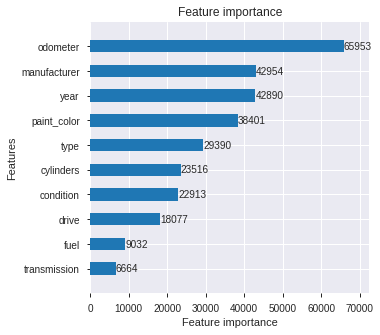

In [44]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

### 5.10 GradientBoostingRegressor with HyperOpt<a class="anchor" id="5.10"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

**Gradient Boosting** builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced. The features are always randomly permuted at each split. Therefore, the best found split may vary, even with the same training data and max_features=n_features, if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, random_state has to be fixed. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [45]:
def hyperopt_gb_score(params):
    clf = GradientBoostingRegressor(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int))            
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.841806074076094
{'max_depth': 4, 'n_estimators': 902}
0.8548750954897038
{'max_depth': 6, 'n_estimators': 697}
0.8507246384156696
{'max_depth': 5, 'n_estimators': 964}
0.8577918144383062
{'max_depth': 8, 'n_estimators': 228}
0.7695608674956012
{'max_depth': 2, 'n_estimators': 152}
0.8621215289447794
{'max_depth': 8, 'n_estimators': 504}
0.796203987199561
{'max_depth': 2, 'n_estimators': 529}
0.8610762478162579
{'max_depth': 8, 'n_estimators': 397}
0.8426431256183455
{'max_depth': 4, 'n_estimators': 982}
0.8500441992800438
{'max_depth': 7, 'n_estimators': 190}
100%|██████████| 10/10 [33:38<00:00, 201.85s/it, best loss: 0.7695608674956012]
best:
{'max_depth': 0, 'n_estimators': 52}


In [46]:
params = space_eval(space_gb, best)
params

{'max_depth': 2, 'n_estimators': 152}

In [47]:
# Gradient Boosting Regression

gradient_boosting = GradientBoostingRegressor(**params)
gradient_boosting.fit(train, target)
acc_model(9,gradient_boosting,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [14961.5547852   8144.2779725  18349.12289052  8255.01119111
  7693.43749231]
acc(r2_score) for train = 77.28
acc(relative error) for train = 18.23
acc(rmse) for train = 411657.37
target_test = [38000 31550  5900 13500 35000]
ytest = [22165.79377043 24544.4268076   5655.52284763 18172.77503809
 29544.87722234]
acc(r2_score) for test = 77.13
acc(relative error) for test = 18.07
acc(rmse) for test = 412264.28


### 5.11 RidgeRegressor <a class="anchor" id="5.11"></a>

[Back to Table of Contents](#0.1)

Tikhonov Regularization, colloquially known as **Ridge Regression**, is the most commonly used regression algorithm to approximate an answer for an equation with no unique solution. This type of problem is very common in machine learning tasks, where the "best" solution must be chosen using limited data. If a unique solution exists, algorithm will return the optimal value. However, if multiple solutions exist, it may choose any of them. Reference [Brilliant.org](https://brilliant.org/wiki/ridge-regression/).

In [48]:
# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(10,ridge,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17220.74260172  8399.64685999 17733.15673909 10137.097247
  6286.78880675]
acc(r2_score) for train = 61.64
acc(relative error) for train = 23.91
acc(rmse) for train = 534865.19
target_test = [38000 31550  5900 13500 35000]
ytest = [20341.45202939 27352.66613376  4434.95517174 19549.19011371
 24916.23870525]
acc(r2_score) for test = 58.44
acc(relative error) for test = 23.89
acc(rmse) for test = 555793.6


### 5.12 BaggingRegressor <a class="anchor" id="5.12"></a>

[Back to Table of Contents](#0.1)

Bootstrap aggregating, also called **Bagging**, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Bagging leads to "improvements for unstable procedures", which include, for example, artificial neural networks, classification and regression trees, and subset selection in linear regression. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors. Reference [Wikipedia](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

In [49]:
# Bagging Regressor

bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(11,bagging,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11768.42666667  8895.89646465 16080.64404762  5501.
  5491.        ]
acc(r2_score) for train = 96.82
acc(relative error) for train = 5.42
acc(rmse) for train = 154048.31
target_test = [38000 31550  5900 13500 35000]
ytest = [34568.2        27752.7         7230.36666667 15702.03333333
 28754.2       ]
acc(r2_score) for test = 84.97
acc(relative error) for test = 12.62
acc(rmse) for test = 334278.98


### 5.13 ExtraTreesRegressor <a class="anchor" id="5.13"></a>

[Back to Table of Contents](#0.1)

**ExtraTreesRegressor** implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html). 

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees).

In [50]:
# Extra Trees Regressor

etr = ExtraTreesRegressor()
etr.fit(train, target)
acc_model(12,etr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11944.    8869.75 15996.25  5600.    5490.  ]
acc(r2_score) for train = 99.31
acc(relative error) for train = 0.96
acc(rmse) for train = 71730.49
target_test = [38000 31550  5900 13500 35000]
ytest = [38000.         26436.5         7131.66666667 15902.8
 29238.625     ]
acc(r2_score) for test = 84.48
acc(relative error) for test = 11.85
acc(rmse) for test = 339694.29


### 5.14 AdaBoost Regressor <a class="anchor" id="5.14"></a>

[Back to Table of Contents](#0.1)

The core principle of **AdaBoost** is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying N weights to each of the training samples. Initially, those weights are all set to 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#adaboost).

In [51]:
# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [15835.37195943 11402.38619231 18848.39831115 11402.38619231
 10433.20446141]
acc(r2_score) for train = 62.49
acc(relative error) for train = 25.49
acc(rmse) for train = 528888.33
target_test = [38000 31550  5900 13500 35000]
ytest = [21845.52346461 21845.52346461  9779.18752758 21053.61972322
 28069.89331493]
acc(r2_score) for test = 62.34
acc(relative error) for test = 25.27
acc(rmse) for test = 529050.27


### 5.15 VotingRegressor <a class="anchor" id="5.15"></a>

[Back to Table of Contents](#0.1)

A **Voting Regressor** is an ensemble meta-estimator that fits base regressors each on the whole dataset. It, then, averages the individual predictions to form a final prediction. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor).

Thanks for the example of ensemling different models from 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor

In [52]:
Voting_Reg = VotingRegressor(estimators=[('lin', linreg), ('ridge', ridge), ('sgd', sgd)])
Voting_Reg.fit(train, target)
acc_model(14,Voting_Reg,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17625.37648275  8193.60357203 17232.30043773 10165.82721418
  6211.29539896]
acc(r2_score) for train = 59.23
acc(relative error) for train = 24.99
acc(rmse) for train = 551429.32
target_test = [38000 31550  5900 13500 35000]
ytest = [19384.24026796 27194.01806816  4267.3255259  19189.61663815
 24980.25820318]
acc(r2_score) for test = 58.33
acc(relative error) for test = 24.88
acc(rmse) for test = 556535.26


## 6. Models comparison <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

We can now compare our models and to choose the best one for our problem.

In [53]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 
              'MLPRegressor', 'Stochastic Gradient Decent', 
              'Decision Tree Regressor', 'Random Forest',  'XGB', 'LGBM',
              'GradientBoostingRegressor', 'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'AdaBoostRegressor', 'VotingRegressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [54]:
pd.options.display.float_format = '{:,.2f}'.format

In [55]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
8,LGBM,89.90,85.77,11.46,13.41,"274,406.60","325,236.32"
11,BaggingRegressor,96.82,84.97,5.42,12.62,"154,048.31","334,278.98"
7,XGB,87.70,84.66,12.95,14.19,"302,861.88","337,698.16"
6,Random Forest,96.75,84.62,5.50,12.75,"155,706.68","338,065.90"
12,ExtraTreesRegressor,99.31,84.48,0.96,11.85,"71,730.49","339,694.29"
9,GradientBoostingRegressor,77.28,77.13,18.23,18.07,"411,657.37","412,264.28"
5,Decision Tree Regressor,99.31,76.61,0.96,14.39,"71,730.45","416,962.33"
3,MLPRegressor,74.20,73.92,19.17,19.05,"438,652.67","440,283.91"
13,AdaBoostRegressor,62.49,62.34,25.49,25.27,"528,888.33","529,050.27"
0,Linear Regression,61.64,58.44,23.91,23.89,"534,865.15","555,802.12"


In [56]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
12,ExtraTreesRegressor,99.31,84.48,0.96,11.85,"71,730.49","339,694.29"
11,BaggingRegressor,96.82,84.97,5.42,12.62,"154,048.31","334,278.98"
6,Random Forest,96.75,84.62,5.50,12.75,"155,706.68","338,065.90"
8,LGBM,89.90,85.77,11.46,13.41,"274,406.60","325,236.32"
7,XGB,87.70,84.66,12.95,14.19,"302,861.88","337,698.16"
5,Decision Tree Regressor,99.31,76.61,0.96,14.39,"71,730.45","416,962.33"
9,GradientBoostingRegressor,77.28,77.13,18.23,18.07,"411,657.37","412,264.28"
3,MLPRegressor,74.20,73.92,19.17,19.05,"438,652.67","440,283.91"
4,Stochastic Gradient Decent,58.67,38.73,23.35,23.57,"555,173.63","674,844.11"
0,Linear Regression,61.64,58.44,23.91,23.89,"534,865.15","555,802.12"


In [57]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
8,LGBM,89.90,85.77,11.46,13.41,"274,406.60","325,236.32"
11,BaggingRegressor,96.82,84.97,5.42,12.62,"154,048.31","334,278.98"
7,XGB,87.70,84.66,12.95,14.19,"302,861.88","337,698.16"
6,Random Forest,96.75,84.62,5.50,12.75,"155,706.68","338,065.90"
12,ExtraTreesRegressor,99.31,84.48,0.96,11.85,"71,730.49","339,694.29"
9,GradientBoostingRegressor,77.28,77.13,18.23,18.07,"411,657.37","412,264.28"
5,Decision Tree Regressor,99.31,76.61,0.96,14.39,"71,730.45","416,962.33"
3,MLPRegressor,74.20,73.92,19.17,19.05,"438,652.67","440,283.91"
13,AdaBoostRegressor,62.49,62.34,25.49,25.27,"528,888.33","529,050.27"
10,RidgeRegressor,61.64,58.44,23.91,23.89,"534,865.19","555,793.60"


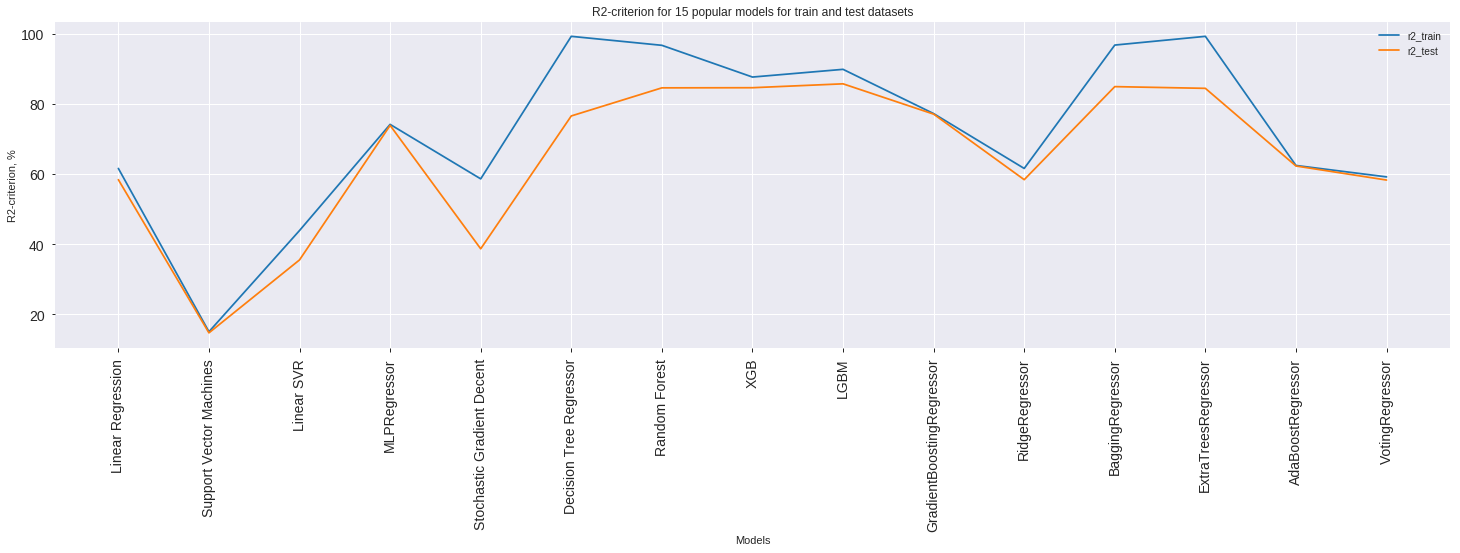

In [58]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

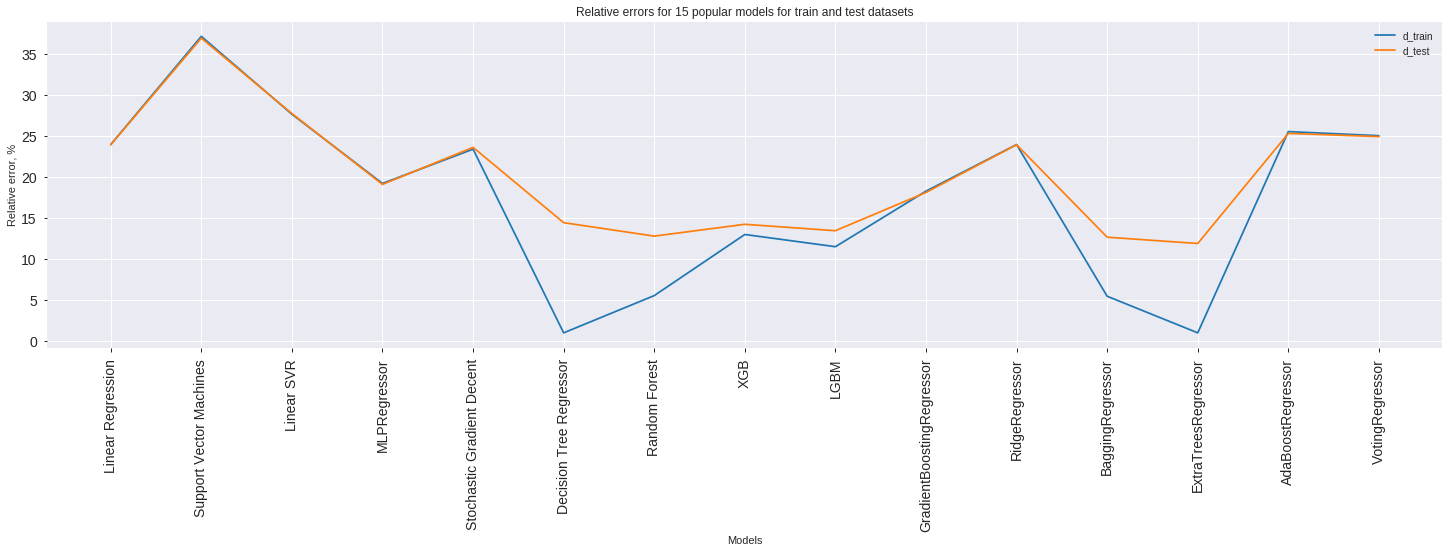

In [59]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

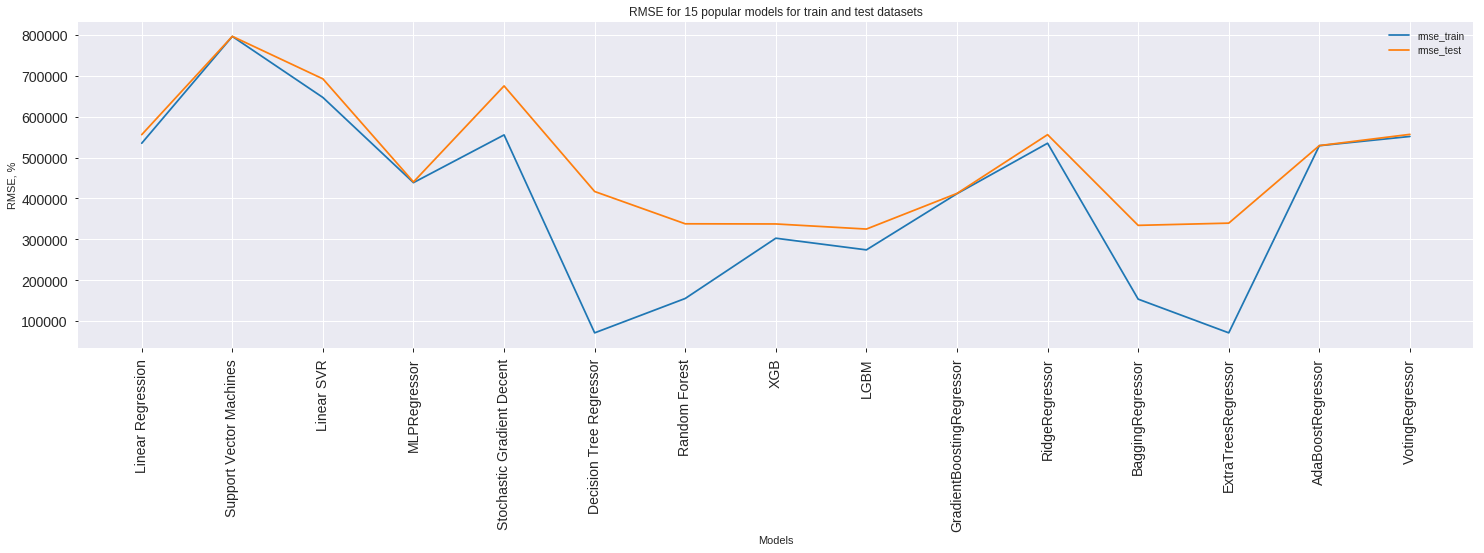

In [60]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

Thus, the best models by the RMSE are Linear Regression and Ridge Regressor.

## 7. Prediction <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

In [61]:
test0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12300 entries, 4125 to 4066
Data columns (total 10 columns):
year            12300 non-null int64
manufacturer    12300 non-null int64
condition       12300 non-null int64
cylinders       12300 non-null int64
fuel            12300 non-null int64
odometer        12300 non-null int64
transmission    12300 non-null int64
drive           12300 non-null int64
type            12300 non-null int64
paint_color     12300 non-null int64
dtypes: int64(10)
memory usage: 1.0 MB


In [62]:
test0.head(3)

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
4125,113,13,2,6,0,39,0,0,10,10
484128,112,7,0,3,2,46,0,1,9,10
144345,115,13,3,5,2,17,0,0,10,10


In [63]:
#For models from Sklearn
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [64]:
#Linear Regression model for basic train
linreg.fit(train0, train_target0)
linreg.predict(testn)[:3]

array([26282.33506249,  5094.20329735, 21368.99522328])

In [65]:
#Ridge Regressor model for basic train
ridge.fit(train0, train_target0)
ridge.predict(testn)[:3]

array([26280.85232725,  5096.58802575, 21368.59620244])

I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)